In [1]:
# Import library
import os
import random

import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize

In [2]:
"""Danh sách các folder chứa ảnh"""
FOLDERS = [
    "person-1", "person-2", "person-3", "person-4", "person-5",
    "person-6", "person-7", "person-8", "person-9", "person-10",
    "person-11", "person-12", "person-13", "person-14", "person-15"
]

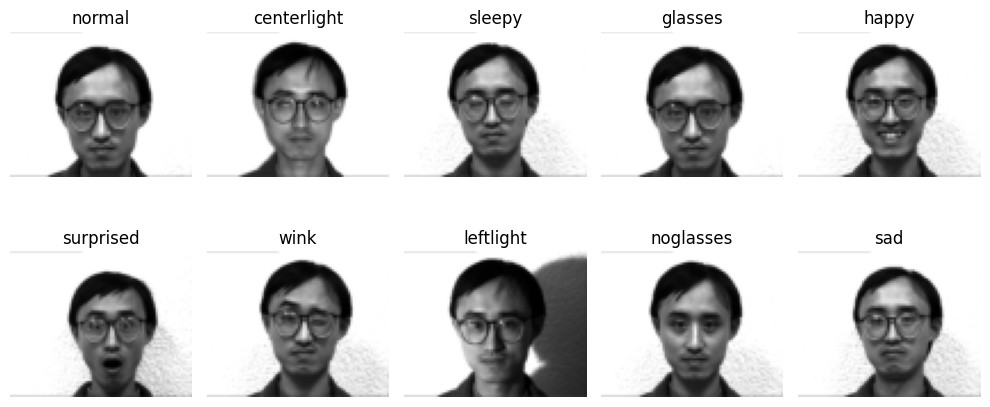

In [3]:
person_folder = random.choice(FOLDERS)
plt.figure(figsize=(10, 5))
for i, file in enumerate(os.listdir(os.path.join("/content/drive/MyDrive/Colab_Notebooks/DS102/yalefaces", person_folder))):
    image = imread(os.path.join("/content/drive/MyDrive/Colab_Notebooks/DS102/yalefaces", person_folder, file))
    image = image.squeeze(0)
    image = resize(image, (64, 80), anti_aliasing=True)
    plt.subplot(2, 5, i+1)
    plt.imshow(image, cmap='gray')
    plt.axis('off') # hide axes
    plt.title(file)

plt.tight_layout()
plt.show()

In [4]:
data = {}
for folder in FOLDERS:
    for file in os.listdir(os.path.join("/content/drive/MyDrive/Colab_Notebooks/DS102/yalefaces", folder)):
        image = imread(os.path.join("/content/drive/MyDrive/Colab_Notebooks/DS102/yalefaces", folder, file))
        image = resize(image, (1, 64, 80), anti_aliasing=True)
        if folder not in data:
            data[folder] = [image]
        else:
            data[folder].append(image)

for person in data:
    data[person] = np.concatenate(data[person], axis=0).reshape(10, -1)

In [5]:
data['person-1'].shape

(10, 5120)

Standarding images

In [6]:
def standardize(images : np.ndarray) -> np.ndarray:
    images = (images - images.mean()) / images.std()
    images = images.astype(np.float32)

    return images

Principle Components Analysis

Implement PCA using Numpy

In [7]:
import numpy as np

class PCA:
    """Phân tích Thành phần Chính (PCA) để giảm chiều dữ liệu."""

    def __init__(self, n_components=1):
        self.n_components = n_components  # Lưu số lượng thành phần chính cần giữ
        self.mean = None
        self.components = None  # Lưu các thành phần chính (vector riêng)
        self.explained_variance = None  # Lưu phương sai được giải thích (giá trị riêng)

    def _center_data(self, X):
        # Căn giữa dữ liệu bằng cách trừ giá trị trung bình của mỗi đặc trưng
        self.mean = np.mean(X, axis=0)  # Tính trung bình của mỗi cột (đặc trưng)
        return X - self.mean  # Trừ trung bình để căn giữa dữ liệu

    def _compute_covariance_matrix(self, X_centered):
        # Tính ma trận hiệp phương sai của dữ liệu đã căn giữa
        n_samples = X_centered.shape[0]  # Lấy số lượng mẫu trong dữ liệu
        # Ma trận hiệp phương sai = (X_centered^T * X_centered) / (n_samples - 1)
        return np.dot(X_centered.T, X_centered) / (n_samples - 1)  # Tính ma trận hiệp phương sai

    def _compute_eigenpairs(self, cov_matrix):
        # Tính giá trị riêng và vector riêng của ma trận hiệp phương sai
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)  # Phân tích giá trị riêng và vector riêng

        # Đảm bảo vector riêng có dấu nhất quán (giá trị tuyệt đối lớn nhất là dương)
        max_abs_idx = np.argmax(np.abs(eigenvectors), axis=0)  # Tìm chỉ số của giá trị tuyệt đối lớn nhất trong mỗi cột
        signs = np.sign(eigenvectors[max_abs_idx, range(eigenvectors.shape[0])])  # Xác định dấu của giá trị tại chỉ số lớn nhất
        eigenvectors = eigenvectors * signs[np.newaxis, :]  # Nhân vector riêng với dấu để thống nhất

        # Tạo danh sách các cặp (giá trị riêng, vector riêng)
        eigen_pairs = [(eigenvalues[i], eigenvectors[:, i]) for i in range(len(eigenvalues))]  # Ghép giá trị riêng và vector riêng thành cặp

        # Sắp xếp các cặp theo giá trị riêng giảm dần
        eigen_pairs.sort(key=lambda pair: pair[0], reverse=True)  # Sắp xếp dựa trên giá trị riêng (từ lớn đến nhỏ)

        # Trích xuất giá trị riêng và vector riêng đã sắp xếp
        sorted_eigenvalues = np.array([pair[0] for pair in eigen_pairs])  # Lấy danh sách giá trị riêng đã sắp xếp
        sorted_eigenvectors = np.array([pair[1] for pair in eigen_pairs]).T  # Lấy ma trận vector riêng đã sắp xếp

        return sorted_eigenvalues, sorted_eigenvectors  # Trả về giá trị riêng và vector riêng đã sắp xếp

    def fit(self, X):
        # Bước 1: Căn giữa dữ liệu
        X_centered = self._center_data(X)  # Gọi hàm căn giữa dữ liệu

        # Bước 2: Tính ma trận hiệp phương sai
        cov_matrix = self._compute_covariance_matrix(X_centered)  # Gọi hàm tính ma trận hiệp phương sai

        # Bước 3: Tính giá trị riêng và vector riêng
        eigenvalues, eigenvectors = self._compute_eigenpairs(cov_matrix)  # Gọi hàm tính giá trị riêng và vector riêng

        # Bước 4: Lưu trữ các thành phần chính hàng đầu
        self.explained_variance = eigenvalues[:self.n_components]  # Lưu n_components giá trị riêng lớn nhất
        self.components = eigenvectors[:, :self.n_components]  # Lưu n_components vector riêng tương ứng

        return self  # Trả về đối tượng PCA đã được huấn luyện

    def transform(self, X):
        # Chiếu dữ liệu lên không gian thành phần chính
        X_centered = X - self.mean  # Căn giữa dữ liệu đầu vào bằng cách trừ trung bình đã lưu

        # Chiếu dữ liệu lên các thành phần chính
        X_projected = np.dot(X_centered, self.components)  # Nhân ma trận dữ liệu với ma trận thành phần chính

        return X_projected  # Trả về dữ liệu đã được giảm chiều

Finding the Priciple Components

In [8]:
pca = PCA(n_components=20)

In [9]:
images = []
for person in data:
    images.append(data[person])
images = np.concatenate(images, axis=0)
images = standardize(images)
images.shape

(150, 5120)

In [10]:
pca.fit(images)

In [11]:
pca.components.shape

(5120, 20)

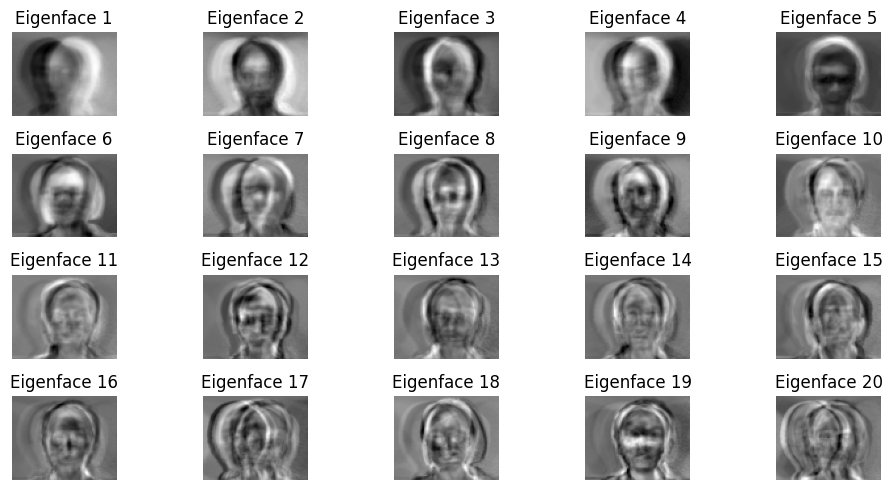

In [13]:
eigen_faces = pca.components.T
eigen_faces = eigen_faces.reshape(20, 64, 80)
plt.figure(figsize=(10, 5))
for i, eigen_face in enumerate(eigen_faces):
    plt.subplot(4, 5, i+1)
    plt.imshow(eigen_face, cmap='gray')
    plt.axis('off')
    plt.title(f'Eigenface {i+1}')

plt.tight_layout()
plt.show()

In [14]:
mean_faces = {person: np.mean(images, axis=0) for person, images in data.items()}

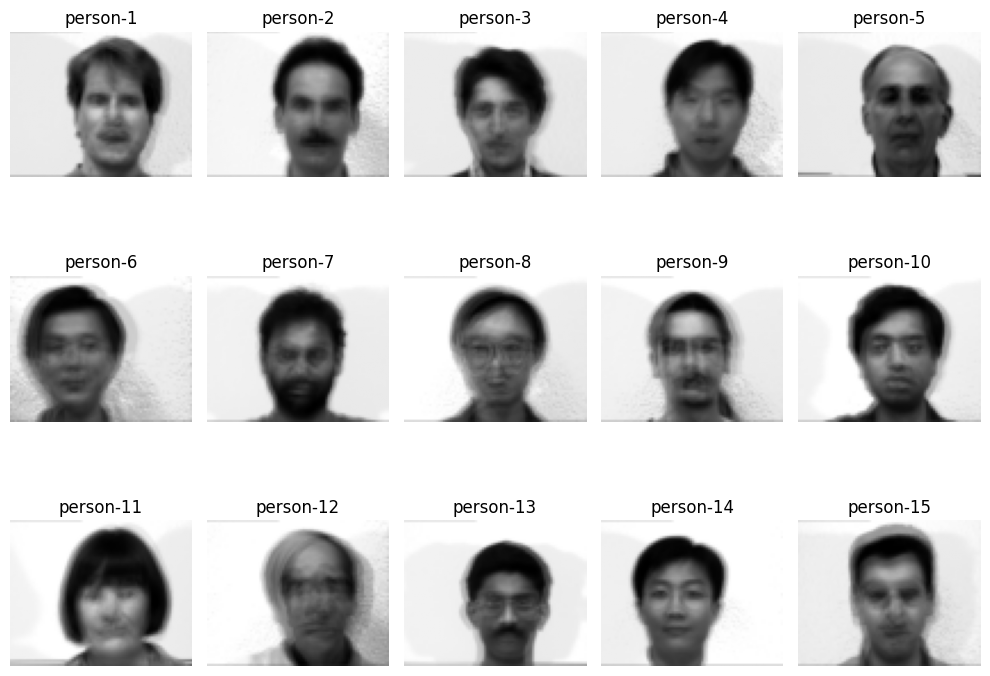

In [15]:
plt.figure(figsize=(10, 8))
for i, person in enumerate(mean_faces):
    mean_face = mean_faces[person]
    mean_face = mean_face.reshape(64, 80)
    plt.subplot(3, 5, i+1)
    plt.imshow(mean_face, cmap='gray')
    plt.axis('off')
    plt.title(person)

plt.tight_layout()
plt.show()

In [16]:
projected_mean_faces = {}
for person in mean_faces:
    projected_mean_faces[person] = pca.transform(mean_faces[person])

In [17]:
labels = []
test_images = []
for file in os.listdir("/content/drive/MyDrive/Colab_Notebooks/DS102/yalefaces/test"):
    person_name = file.split('.')[0]
    labels.append(person_name)
    image = imread(os.path.join("/content/drive/MyDrive/Colab_Notebooks/DS102/yalefaces/test", file))
    image = resize(image, (1, 64, 80), anti_aliasing=True)
    test_images.append(image)

In [18]:
test_images = np.concatenate(test_images, axis=0)
test_images.shape

(15, 64, 80)

In [19]:
labels

['person-3',
 'person-13',
 'person-5',
 'person-8',
 'person-4',
 'person-2',
 'person-12',
 'person-11',
 'person-15',
 'person-10',
 'person-1',
 'person-14',
 'person-7',
 'person-6',
 'person-9']

In [20]:
def euclid_dis(X, Y):
    assert X.shape == Y.shape, f"{X.__str__()} and {Y.__str__()} are miss-shaped"
    return (((X - Y)**2).sum())**0.5

In [21]:
predicts = {}
for label, image in zip(labels, test_images):
    image = image.reshape(-1)
    projected_face = pca.transform(image)
    close_dis = np.inf
    close_person = None
    for person in projected_mean_faces:
        mean_face = projected_mean_faces[person]
        dis = euclid_dis(mean_face, projected_face)
        if dis < close_dis:
            close_dis = dis
            close_person = person
    predicts[label] = close_person

In [22]:
EMs = []
for label in predicts:
    EMs.append(label == predicts[label])
print(f'Accuracy: {np.mean(EMs)*100:0.2f}')

Accuracy: 66.67
